# WaveNet Sample Generation
Fast generation of samples from a pretrained WaveNet model

In [1]:
from wavenet_model import WaveNetModel
from wavenet_training import AudioFileLoader, WaveNetOptimizer

import torch
import numpy as np
import time

from IPython.display import Audio
from matplotlib import pyplot as plt
from matplotlib import pylab as pl
from IPython import display

%matplotlib notebook

## Load Model

In [8]:
train_samples = ["train_samples/bach_full.wav"]
sampling_rate = 11025

parameters = "model_parameters/bach_10-5-256-32-32-256-2"

layers = 10
blocks = 5
classes = 256
dilation_channels = 32
residual_channels = 32
skip_channels = 256
kernel_size = 2
dtype = torch.FloatTensor
ltype = torch.LongTensor

use_cuda = torch.cuda.is_available()
if use_cuda:
    dtype = torch.cuda.FloatTensor
    ltype = torch.cuda.LongTensor

In [9]:
model = WaveNetModel(layers=layers,
                     blocks=blocks,
                     dilation_channels=dilation_channels,
                     residual_channels=residual_channels,
                     skip_channels=skip_channels,
                     classes=classes,
                     kernel_size=kernel_size,
                     dtype=dtype)

if use_cuda:
    model.cuda()
    print("use cuda")

#print("model: ", model)
print("receptive_field: ", model.receptive_field)

if use_cuda:
    model.load_state_dict(torch.load(parameters))
else:
    # move to cpu
    model.load_state_dict(torch.load(parameters, map_location=lambda storage, loc: storage))

data_loader = AudioFileLoader(train_samples,
                              classes=classes,
                              max_load_duration=600.,
                              dtype=dtype,
                              ltype=ltype,
                              sampling_rate=sampling_rate)

receptive_field:  5627
total duration of training data:  141.374693877551  s


new epoch
load new chunk
data from  train_samples/bach_full.wav
load new chunk
data from  train_samples/bach_full.wav


<IPython.core.display.Javascript object>


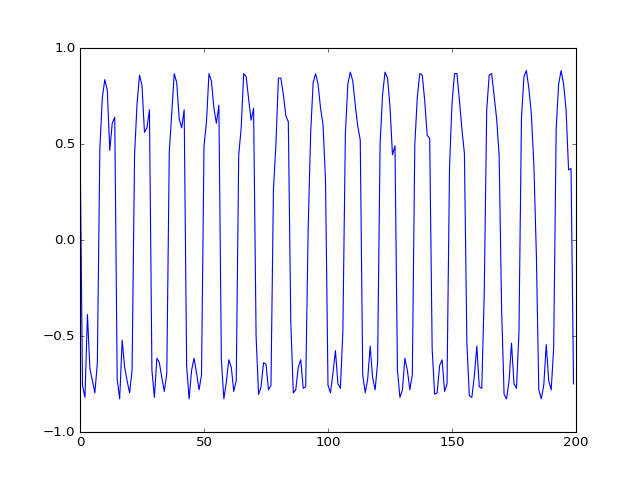

In [18]:
data_loader.start_new_epoch()
start_data = data_loader.get_wavenet_minibatch([model.receptive_field], 
                                               model.receptive_field,
                                               model.output_length)[0]
start_data = start_data.squeeze()
#start_tensor = torch.zeros((model.scope)) + 0.0

plt.plot(start_data.cpu().numpy()[-200:])

## Generate Samples


In [19]:
num_samples = 11025 # number of samples that will be generated
out_file = "generated_samples/bach_10-5-256-32-32-256-2.wav"

In [20]:
from ipywidgets import FloatProgress
from IPython.display import display
progress = FloatProgress(min=0, max=100)
display(progress)

def p_callback(i, total):
    progress.value += 1

tic = time.time()
generated_sample = model.generate_fast(num_samples, 
                                       #first_samples=start_data,
                                       first_samples=torch.zeros((1)),
                                       progress_callback=p_callback,
                                       sampled_generation=False,
                                       temperature=1.0)
toc = time.time()
print('Generating took {} seconds.'.format(toc-tic))

Generating took 271.34884905815125 seconds.


<IPython.core.display.Javascript object>


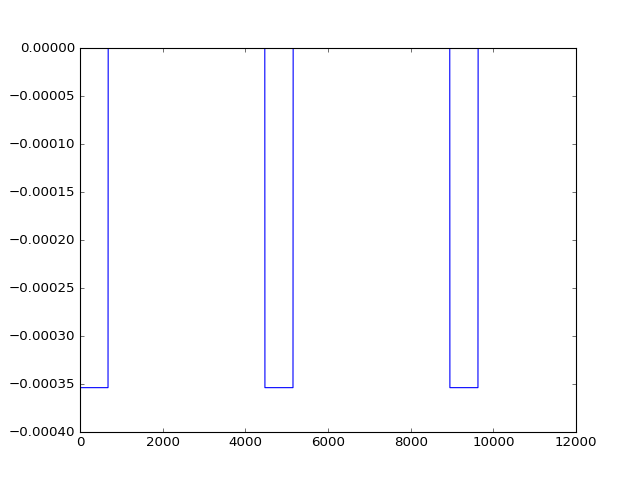

In [23]:
fig = plt.figure()
plt.plot(generated_sample)

from IPython.display import Audio
Audio(np.array(generated_sample), rate=sampling_rate)

In [ ]:
print(np.array(generated_sample))

from scipy.io import wavfile
wavfile.write(out_file, sample_rate, np.array(generated_sample))